In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool
import shap
from feature_mapping import map_feature

/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_who_ref = pd.read_excel('../WHO_tables/bmi-boys-perc-who2007-exp.xlsx')

In [5]:
# Define the age range and convert it to months
age_years = list(range(7, 19))  # From 7 to 18 years inclusive
age_months = [age * 12 for age in age_years]

# Filter the dataset for the specified months and select relevant columns
filtered_df = df_who_ref[df_who_ref['Month'].isin(age_months)][['Month', 'P5', 'P15', 'P85', 'P95']]

# Map months back to years for clarity
filtered_df['Age'] = filtered_df['Month'] // 12
filtered_df = filtered_df.drop(columns=['Month'])

filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,P5,P15,P85,P95,Age
0,13.504,14.166,17.111,18.261,7
1,13.666,14.350,17.508,18.802,8
2,13.866,14.579,17.987,19.453,9
3,14.127,14.875,18.568,20.225,10
4,14.469,15.260,19.260,21.113,11
5,14.891,15.734,20.052,22.090,12
6,15.402,16.303,20.943,23.144,13
7,15.976,16.941,21.891,24.221,14
8,16.547,17.580,22.812,25.229,15
9,17.078,18.176,23.656,26.126,16


In [6]:
df_5 = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=False)
df_5.shape

(13983, 382)

In [7]:
df_5 = df_5.rename(columns=map_feature)

In [8]:
df_5.gender.unique()

array([0., 1.])

In [9]:
df_5 = df_5[df_5['gender']==1]

In [10]:
df_5 = df_5.drop(['var00001', 'univers0', 'region2', 'cluster2', 'cross2', 'sex2', 'birth_y0', 'sample_0','sample_c'],axis=1)

In [11]:
def preprocess(dataframes_dict):
    processed_dfs = {}  # Dictionary to store processed DataFrames
    for name, df_org in dataframes_dict.items():
        df = df_org.copy()
        df.replace('', np.nan, inplace=True)
        df.replace('?', np.nan, inplace=True)
        # Filter age
        df = df[(df["age"] >= 7) & (df["age"] <= 18)]

        # Convert height and weight to numeric
        df['height'] = pd.to_numeric(df['height'], errors='coerce')
        df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

        # Calculate BMI
        df["bmi1"] = df["weight"] / ((df["height"] / 100) ** 2)

        # Remove null tuples
        records_with_nulls = df[
            df["gender"].isna()
        ]
        df = df.dropna(subset=["gender"])
        missing_percent = df.isna().mean()
        threshold = 0.8
        df = df.loc[:, missing_percent <= threshold]

        # Fill missing values by grouping by age and using the mode
        for col in df.columns:
            if df[col].isna().any():  # Only process columns with missing values
                df[col] = df.groupby('age')[col].transform(
                    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
                )

        print(
            f"Number of records with NaN value in sex in {name}: {len(records_with_nulls)}"
        )

        # Store the processed DataFrame in the new dictionary
        processed_dfs[name] = df

    return processed_dfs

def calculate_percentile_labels(row, who_ref):
    """
    Categorizes BMI based on WHO reference percentiles for the corresponding age.
    """
    age = row['age']
    bmi = row['bmi1']
    
    # Filter WHO reference data for the specific age
    ref_data = who_ref[who_ref['Age'] == age]
    
    if ref_data.empty:
        return 'Unknown'  # Handle cases where reference data is not available
    
    # Extract the percentiles
    p5 = ref_data['P5'].values[0]
    p85 = ref_data['P85'].values[0]
    p95 = ref_data['P95'].values[0]
    
    # Categorize based on percentiles
    if bmi < p5:
        return 'Underweight'
    elif p5 <= bmi < p85:
        return 'Normal'
    elif p85 <= bmi < p95:
        return 'Overweight'
    else:
        return 'Obese'

def calculate_percentiles(processed_dfs, who_ref):
    """
    Adds a percentile category for each row based on WHO reference data.
    """
    for name_df, df_org in processed_dfs.items():
        df = df_org.copy()
        
        # Apply the function to calculate percentile categories
        df['bmi1_category'] = df.apply(
            lambda row: calculate_percentile_labels(row, who_ref), axis=1
        )
        
        # Update the processed DataFrame
        processed_dfs[name_df] = df

    return processed_dfs

input_dfs = {'casp5': df_5}  # Replace with your actual dataframe

# Preprocess the input data
processed_dataframes = preprocess(input_dfs)

# Use the WHO reference dataframe (df_who_ref)
final_dfs = calculate_percentiles(processed_dataframes, filtered_df)

# Save or output the final results
for name, df in final_dfs.items():
    print(f"Processed DataFrame for {name}:")
    print(df.head())

Number of records with NaN value in sex in casp5: 0
Processed DataFrame for casp5:
             id2  university  region  cluster  grade  gender  birth_date  \
2   4.103118e+09         4.0     1.0      3.0    1.0     1.0        80.0   
3   5.011112e+10        50.0     1.0     11.0    1.0     1.0        80.0   
4   4.123522e+10        41.0     2.0     35.0    2.0     1.0        79.0   
9   4.114218e+09         4.0     1.0     14.0    2.0     1.0        77.0   
10  3.104119e+09         3.0     1.0      4.0    1.0     1.0        85.0   

    close_friend_count  spent_time_friend1  spent_time_friend2  ...  hp_98  \
2                  4.0                 4.0                 5.0  ...    1.0   
3                  4.0                 1.0                 1.0  ...    2.0   
4                  4.0                 3.0                 2.0  ...    1.0   
9                  4.0                 1.0                 3.0  ...    1.0   
10                 4.0                 3.0                 3.0  ...   

/tmp/ipykernel_30002/796034743.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


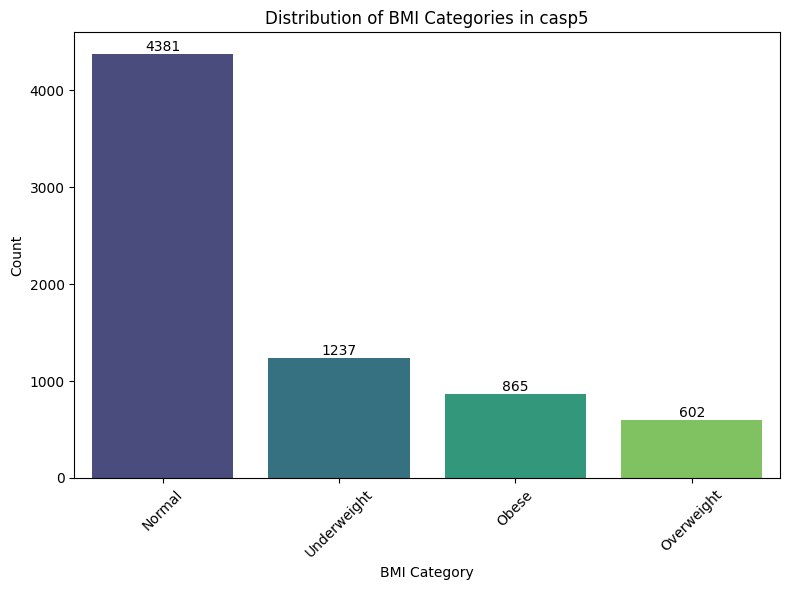

In [12]:
def plot_bmi_categories(processed_dfs, feature):
    for name, df in processed_dfs.items():
        # Count the occurrences of each category
        category_counts = df[f'{feature}_category'].value_counts()

        # Plot the counts
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

        # Annotate counts above each bar
        for i, count in enumerate(category_counts.values):
            ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

        # Customize plot
        plt.title(f"Distribution of BMI Categories in {name}")
        plt.xlabel("BMI Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_bmi_categories(processed_dataframes,'bmi1')


In [13]:
df_encoded = final_dfs['casp5']
class_mapping = {'Underweight':0,'Normal':1,'Overweight':2,'Obese':3}
df_encoded['bmi1_category']=df_encoded['bmi1_category'].map(class_mapping)
df_encoded['bmi1_category'] = pd.to_numeric(df_encoded['bmi1_category'])
print(df_encoded['bmi1_category'].value_counts())

1    4381
0    1237
3     865
2     602
Name: bmi1_category, dtype: int64


Class distribution before balancing:
 1    1689
0     476
3     355
2     253
Name: bmi1_category, dtype: int64
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

Confusion Matrix for age 2.0:
[[25 11  8  7]
 [15 10 15 10]
 [10  8 15 18]
 [ 5 11 13 22]]


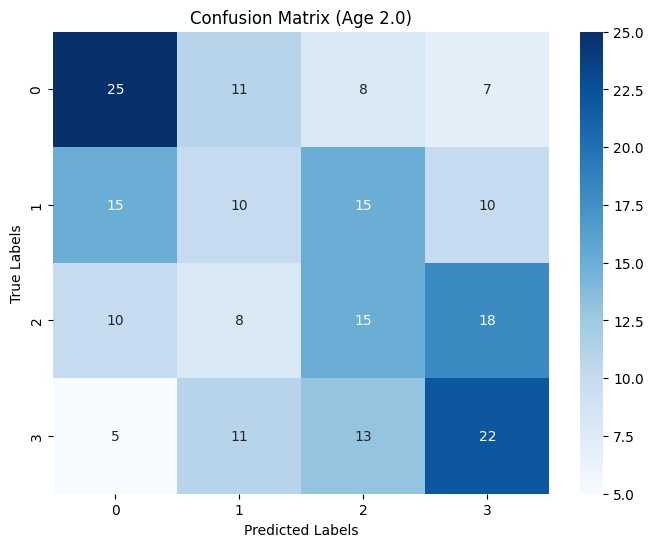

Class distribution before balancing:
 1    1264
0     345
3     221
2     179
Name: bmi1_category, dtype: int64
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

Confusion Matrix for age 3.0:
[[18  8  5  5]
 [ 4  7 11 14]
 [ 1 14 13  8]
 [ 6  9  7 14]]


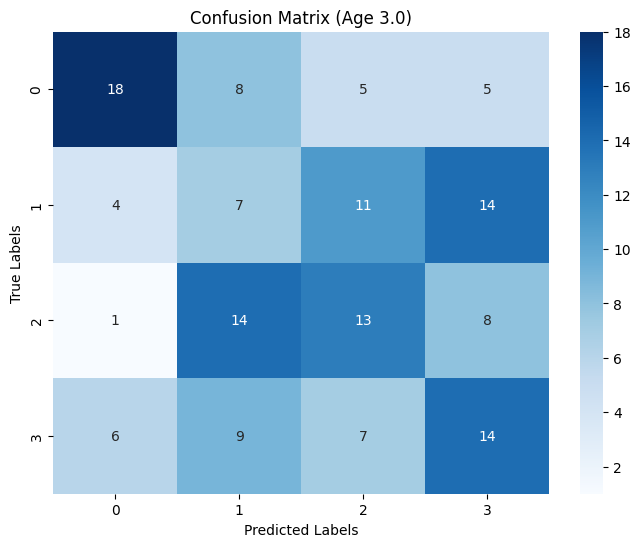

Class distribution before balancing:
 1    1428
0     416
3     289
2     170
Name: bmi1_category, dtype: int64
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/atefe_hjn97/Documents/VScode/caspian_second/CASPIAN_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:39:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

Confusion Matrix for age 1.0:
[[11  9  7  7]
 [12  7 11  4]
 [ 4 10 11  9]
 [ 2  9 12 11]]


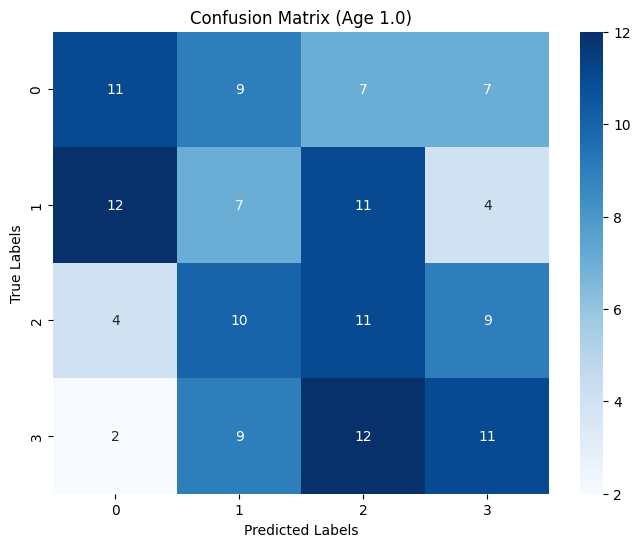

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_mat, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

def split_X_y(df_org):
    df = df_org.copy()
    
    # Get the minimum class count
    class_counts = df['bmi1_category'].value_counts()
    min_class_count = class_counts.min()
    print("Class distribution before balancing:\n", class_counts)
    
    # # Balance the dataset
    balanced_df = df.groupby('bmi1_category').apply(
        lambda x: x.sample(n=min(len(x), min_class_count))
    ).reset_index(drop=True)
    
    # Define the feature set X and the target y
    X = balanced_df.drop(columns=[
        'weight', 'bmi1', 'id2', 'hip', 'neck', 'wrist', 'waist', 'cluster',
        'catage', 'height', 'bmi1', 'bmi1_category', 'hp_101', 'body_image',
        'hp_100', 'hp_101', 'hp_102', 'hp_103', 'hp_104', 'hp_105', 'birth_date'
    ], axis=1, errors='ignore')  # Use errors='ignore' to avoid KeyError if any column is missing
    y = balanced_df['bmi1_category']
    
    # Print shapes for verification
    # print("Class distribution after balancing:\n", balanced_df['bmi1_category'].value_counts())
    
    return X, y


def train_catboost(X_train, y_train, iterations=100, random_state=42):
    model = CatBoostClassifier(
        max_depth=10,
        iterations=iterations,
        random_seed=random_state,
        verbose=0
    )
    model.fit(X_train, y_train)
    return model
def train_xgboost(X_train, y_train, random_state=42):
    # Define the model
    model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric="logloss")

    # Define the parameter grid to search over
    param_grid = {
        'n_estimators': [ 100, 200],          # Number of estimators
        'learning_rate': [0.01, 0.1],      # Learning rate
        'max_depth': [ 5, 7,12],                   # Maximum depth of trees
        # 'subsample': [0.7, 0.8, 1.0],             # Subsample ratio
        'colsample_bytree': [0.7, 0.8, 1.0]       # Column sample by tree
    }

    # Set up the grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

    # Fit the model with grid search
    grid_search.fit(X_train, y_train)

    # Return the best model and the best parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    return best_model, best_params

def train_mlp(X_train, y_train, hidden_layer_sizes=(150,), random_state=42):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    return model,hidden_layer_sizes


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion_mat = confusion_matrix(y_test, y_pred)
    
    return {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": confusion_mat
    }


def process_and_train_model_for_each_age(final_dfs, catage, k=20, tolerance=1e-6):
    for name, df in final_dfs.items():
        results = []
        for cat in catage:
            # Filter dataset for the specific age
            df_age = df[np.isclose(df['catage'], cat, atol=tolerance)]

            if df_age.empty:
                continue

            X, y = split_X_y(df_age)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
            # Train the model on the resampled training data
            # best_model = train_catboost(X_train, y_train)
            best_model,params = train_xgboost(X_train,y_train)
            # Evaluate the model
            mlp_model_metrics = evaluate_model(best_model, X_test, y_test)
            
            # Append results
            results.append({
                "catage": cat,
                "accuracy": mlp_model_metrics['accuracy'],
                "num_samples": len(df_age),
                "classification_report": mlp_model_metrics['report']
            })
            
            # Print confusion matrix
            print(f"Confusion Matrix for age {cat}:")
            print(mlp_model_metrics['confusion_matrix'])
            
            # Plot confusion matrix
            class_names = list(np.unique(y))  # Ensure unique class labels
            plot_confusion_matrix(mlp_model_metrics['confusion_matrix'], class_names, title=f"Confusion Matrix (Age {cat})")

        return results

input_dfs = {'casp5':df_encoded}
catage = df_encoded['catage'].unique()
# results = process_and_train_model_for_each_age(final_dfs,catage)
results = process_and_train_model_for_each_age(input_dfs,catage)

results_df = pd.DataFrame([{
"catage": r["catage"],
"accuracy": r["accuracy"],
"num_samples": r["num_samples"],
# "top_features": r["top_features"],
"classification_report": r["classification_report"]
} for r in results])

# results_df.to_csv("catage_based_model_results_boys_casp5.csv", index=False)
# print("Results saved to catage_based_model_results.csv.")

In [35]:
results

[{'catage': 2.0,
  'accuracy': 0.35467980295566504,
  'num_samples': 2773,
  'classification_report': {'0': {'precision': 0.45454545454545453,
    'recall': 0.49019607843137253,
    'f1-score': 0.4716981132075472,
    'support': 51.0},
   '1': {'precision': 0.25,
    'recall': 0.2,
    'f1-score': 0.2222222222222222,
    'support': 50.0},
   '2': {'precision': 0.29411764705882354,
    'recall': 0.29411764705882354,
    'f1-score': 0.29411764705882354,
    'support': 51.0},
   '3': {'precision': 0.38596491228070173,
    'recall': 0.43137254901960786,
    'f1-score': 0.4074074074074074,
    'support': 51.0},
   'accuracy': 0.35467980295566504,
   'macro avg': {'precision': 0.346157003471245,
    'recall': 0.353921568627451,
    'f1-score': 0.3488613474740001,
    'support': 203.0},
   'weighted avg': {'precision': 0.3466306832913003,
    'recall': 0.35467980295566504,
    'f1-score': 0.3494851855294276,
    'support': 203.0}}},
 {'catage': 3.0,
  'accuracy': 0.3611111111111111,
  'num_sa